# Load libraries 

In [100]:
import os
os.mkdir("../images")
#print(os.environ["CUDA_DEVICE_ORDER"])
#print(os.environ["CUDA_VISIBLE_DEVICES"])
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

FileExistsError: [Errno 17] File exists: '../images'

In [25]:
#load libraries 
from matplotlib.offsetbox import AnchoredText
import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines , numpy as np,cupy as cp, math, pylab
#import cudf
#import ROOT
#from ROOT import TFile

#import root_pandas

from toggle_cell import hide_cell 
import uproot3
%matplotlib inline

#presets for plot style
from scipy.constants import golden
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 7/golden),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

from scipy.optimize import curve_fit

import misc_util


# Load tuple files  

In [ ]:
data_dihadrons = uproot3.open('../in/data_dihadrons_30pc.root')['dihadrons'].pandas.df()
mc_dihadrons = uproot3.open('../in/mc_dihadrons.root')['dihadrons'].pandas.df()

In [143]:
data_triggers = pd.read_pickle('../in/data_hadrons_trigger_30pc.pkl')
#data_dipions = uproot3.open('../in/data_dipions.root')['dipions'].pandas.df()

Now load the tuples from the files.

In [146]:
for df in data_dihadrons,mc_dihadrons:
    df['diff_phi_shift'] = df.diff_phi_cm + (2*np.pi)*(df.diff_phi_cm<-np.pi/2)
    
mc_dihadrons['diff_phi_shift_truth'] = df.diff_phi_cm_truth + (2*np.pi)*(df.diff_phi_cm_truth<-np.pi/2)

In [28]:
#print the number of entries in each tuple
print("data dihadrons \tlength =", len(data_dihadrons))
print("data dipions \tlength =", len(data_dipions))

data dihadrons 	length = 882585
data dipions 	length = 8099842


In [39]:
expr = "sqrt((E+.93827208816-sqrt(e_p**2+.000511**2)-sqrt(h1_p**2+((abs(h1_pid)==211)*.13957018+(abs(h1_pid)==321)*.493677+(abs(h1_pid)==2212)*.93827208816)**2)"+\
   "-sqrt(h2_p**2+((abs(h2_pid)==211)*.13957018+(abs(h2_pid)==321)*.493677+(abs(h2_pid)==2212)*.93827208816)**2))**2"+\
       "-(E-e_p*cos(e_th)-h1_p*cos(h1_th)-h2_p*cos(h2_th))**2"+\
       "-(-e_p*sin(e_th)*cos(e_ph)-h1_p*sin(h1_th)*cos(h1_ph)-h2_p*sin(h2_th)*cos(h2_ph))**2"+\
       "-(-e_p*sin(e_th)*sin(e_ph)-h1_p*sin(h1_th)*sin(h1_ph)-h2_p*sin(h2_th)*sin(h2_ph))**2)"

mc_dihadrons['mx_eh1h2x'] = mc_dihadrons.eval(expr)

expr = "sqrt((sqrt(h1_p**2+((abs(h1_pid)==211)*.13957018+(abs(h1_pid)==321)*.493677+(abs(h1_pid)==2212)*.93827208816)**2)"+\
   "+sqrt(h2_p**2+((abs(h2_pid)==211)*.13957018+(abs(h2_pid)==321)*.493677+(abs(h2_pid)==2212)*.93827208816)**2))**2"+\
       "-(h1_p*cos(h1_th)+h2_p*cos(h2_th))**2"+\
       "-(h1_p*sin(h1_th)*cos(h1_ph)+h2_p*sin(h2_th)*cos(h2_ph))**2"+\
       "-(h1_p*sin(h1_th)*sin(h1_ph)+h2_p*sin(h2_th)*sin(h2_ph))**2)"

mc_dihadrons['pair_mass'] = mc_dihadrons.eval(expr)

expr = "sqrt((E+.93827208816-sqrt(e_p**2+.000511**2)"+\
   "-sqrt(h2_p**2+((abs(h2_pid)==211)*.13957018+(abs(h2_pid)==321)*.493677+(abs(h2_pid)==2212)*.93827208816)**2))**2"+\
       "-(E-e_p*cos(e_th)-h2_p*cos(h2_th))**2"+\
       "-(-e_p*sin(e_th)*cos(e_ph)-h2_p*sin(h2_th)*cos(h2_ph))**2"+\
       "-(-e_p*sin(e_th)*sin(e_ph)-h2_p*sin(h2_th)*sin(h2_ph))**2)"

mc_dihadrons['mx_eh2x'] = mc_dihadrons.eval(expr)

expr = "sqrt((E+.93827208816-sqrt(e_p**2+.000511**2)"+\
   "-sqrt(h1_p**2+((abs(h1_pid)==211)*.13957018+(abs(h1_pid)==321)*.493677+(abs(h1_pid)==2212)*.93827208816)**2))**2"+\
       "-(E-e_p*cos(e_th)-h1_p*cos(h1_th))**2"+\
       "-(-e_p*sin(e_th)*cos(e_ph)-h1_p*sin(h1_th)*cos(h1_ph))**2"+\
       "-(-e_p*sin(e_th)*sin(e_ph)-h1_p*sin(h1_th)*sin(h1_ph))**2)"

mc_dihadrons['mx_eh1x'] = mc_dihadrons.eval(expr)

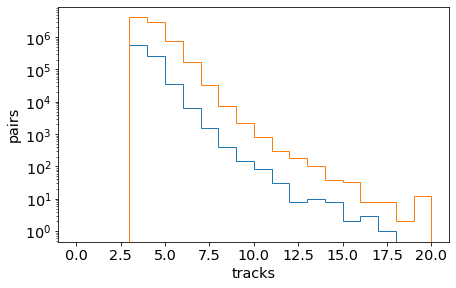

In [40]:
maxtracks = 20
plt.hist(data_dihadrons.ntracks,bins=maxtracks,range=(0,maxtracks),histtype='step')
plt.hist(data_dipions.ntracks,bins=maxtracks,range=(0,maxtracks),histtype='step')
plt.gca().set_xlabel("tracks")
plt.gca().set_yscale('log')
plt.gca().set_ylabel("pairs")
plt.show()

In [41]:
import scipy.optimize
def yridge(df,n=3,bins = 50,debugplots = False):
    x,y,dy=[],[],[]
    denom = len(df)*2*np.pi/bins
    for xmid, bindf in misc_util.BinIterator(df, "abs(diff_phi_cm)", 0,np.pi,bins):
        x.append(xmid)
        y.append(len(bindf)/denom)
        dyi = np.sqrt(len(bindf))/denom
        dyi=dyi
        if xmid<0.1 or xmid>2:
            dyi = 1000;
        dy.append(dyi)
    x = pd.Series(x)
    y = pd.Series(y)
    dy = pd.Series(dy)
    def f (xx,b0,b1,b2,b3):
        args=[b0,b1,b2,b3]
        tot = 0
        for i in range(len(args)):
            tot+=args[i]*np.cos(i*xx)
        return tot
    b,bcov = scipy.optimize.curve_fit(f, x, y,sigma=dy)
    #b = [2*sum(y*np.cos(i*x)/dy**2)/sum(1/dy**2) for i in range(0,n+1)]
    #b = [2*sum(y*np.cos(i*x))/len(x) for i in range(0,n+1)]
    #b[0]/=2
   
    s = 0
    for i in range(0,n+1):
        s = b[i]*np.cos(i*x)+s
    if(debugplots):
        print(b)
        plt.errorbar(x,y,dy,linestyle='',marker='o',color='k')
        plt.plot(x,s,linestyle='-')
        plt.gca().set_ylim(-1,1)
    
    smin = s[0]
    xmin=0
    for xi,si in zip(x,s):
        if(si<smin):
            xmin = xi
            smin = si
    integral = 0
    dx = x[1]-x[0]
    for xi,si in zip(x,s):
        if(xi<xmin):
            integral+=(si-smin)*dx
        else:
            break
    return integral
    

In [42]:
df = data_dihadrons.query("h1_cm_eta-h2_cm_eta>2.0 and h1_cm_eta-h2_cm_eta<200.0 and h1_cm_pt>0.3 and h2_cm_pt>0.3"\
        + " and h1_cm_pt<3 and h2_pid == 2212 and mx_eh1x>1.665")

print(yridge(df, ))



0


(array([ 81471.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 801114.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

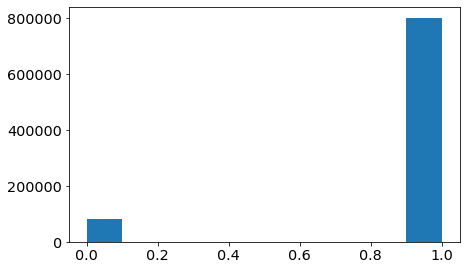

In [139]:
df = data_dihadrons
a = [1]+[0 if df.Q2[i] ==df.Q2[i-1] else 1 for i in range(1,len(df))]
df['new_event'] = a
plt.hist(df.new_event)

In [144]:
import misc_util

def azimuthalPlot(df,df_trig,n=4,bins = 50, includeResiduals=False,includeLegend=True,style='normal',expr='diff_phi_shift',
                 normalize_properly=True):
    if(includeResiduals):
        fig,axs = plt.subplots(2,1, figsize=(7,7), gridspec_kw={'height_ratios': [3, 1]}, 
                              sharex='all')
        plt.sca(axs[0])
    x,y,dy = [],[],[]
    
    denom = len(df_trig)*2*np.pi/bins
    
    for xmid, bindf in misc_util.BinIterator(df, expr, -np.pi/2,np.pi*3/2,bins):
        x.append(xmid)
        y.append(len(bindf)/denom)
        dy.append(np.sqrt(len(bindf))/denom)
    x = pd.Series(x)
    y = pd.Series(y)
    dy = pd.Series(dy)
    if style== 'normal':
        plt.errorbar(x,y,dy,marker='o',color='k',linestyle='')
        plt.axhline(0,color='0.7',linestyle=':')
        #a = [2*sum(y*np.sin(i*x))/len(x) for i in range(0,n+1)]
        #remove sin term
        #a = [0 for i in range(0,n+1)]
        b = [2*sum(y*np.cos(i*x))/len(x) for i in range(0,n+1)]
        b[0]/=2
        s = 0
        for i in range(0,n+1):
            s = b[i]*np.cos(i*x)+s
        plt.plot(x,s,linestyle='-',color='k',label='all')
        for i in range(1,n+1):
            plt.plot(x,b[i]*np.cos(i*x)+b[0]*(i!=0),linestyle='--', label="n=%s"%i)
        plt.gca().set_xlim(-np.pi/2,np.pi*3/2)
        plt.gca().set_ylabel("$\\frac{1}{N_{\\mathrm{tot}}}\\frac{dN}{d\\Delta\\phi}$",rotation=0,fontsize=20,labelpad=25)
    elif style=='bar':
        plt.gca().bar(x,y,x[1]-x[0],alpha=0.3,color='tab:pink')
    if not includeResiduals:
        plt.gca().set_xlabel("$\\Delta\\phi$ [rad]")
    if includeLegend:
        legend = plt.gca().legend(title="Fourier fit",loc='upper left')
        plt.setp(legend.get_title(),fontsize=12)
    if includeResiduals:
        plt.sca(axs[1])
        plt.errorbar(x,(y-s)/dy,1,marker='o',color='k',linestyle='')
        plt.gca().set_xlabel("$\\Delta\\phi$ [rad]")
        axs[1].set_ylabel('normed residual')
        #lims = axs[0].get_ylim()
        #axs[1].set_ylim(-(lims[1]-lims[0])/6,(lims[1]-lims[0])/6)
        plt.sca(axs[0])
        plt.subplots_adjust(hspace=0)

hide_cell()

TypeError: object of type 'NoneType' has no len()

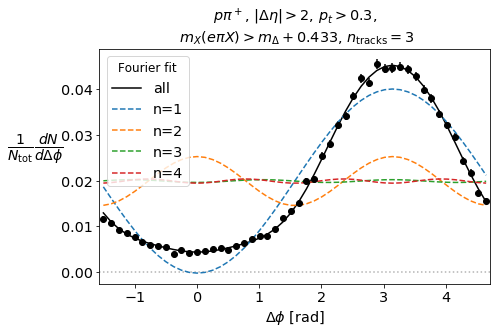

In [148]:
#check if the normalization works.
#properly normalized is 0
df = data_dihadrons.query("h1_cm_eta-h2_cm_eta>2.0 and h1_cm_eta-h2_cm_eta<200.0 and h1_cm_pt>0.3 and h2_cm_pt>0.3"\
        + " and h2_pid == 2212 and mx_eh1x>1.665 and nhtracks==3")
df_trig = data_triggers.query("h_cm_pt>0.3 and nhtracks==3")
azimuthalPlot(df,df_trig,n=4,bins = 50)
plt.gca().set_title("$p\\pi^+$, $|\\Delta\\eta|>2$, $p_t>0.3$,\n $m_X(e\\pi X)>m_\\Delta+0.433$, $n_{\\mathrm{tracks}}=3$")
#azimuthalPlot(df,None,n=4,bins = 50,style='bar',normalize_properly=False)



In [45]:
import scipy.optimize,numpy.random,time,os
def upper_limit_yridge(df,n=3,bins = 100,miniterations=100,maxiterations=200000,fitrange=(0,np.pi),
                       progressPrintInterval=None, #print stats after every [...] iterations (don't print if 0)
                       sayDone=False):
    if len(df) == 0:
        return 1, 1.0, 0,0
    start = time.perf_counter()
    x,y,dy,w=[],[],[],[]
    denom = len(df)*2*np.pi/bins
    for xmid, bindf in misc_util.BinIterator(df, "abs(diff_phi_shift)", 0,np.pi,bins):
        x.append(xmid)
        num = len(bindf)
        y.append(num/denom)
        dyi =np.sqrt(max(num,1)*max(denom-num,1))/max(denom,1)**(3/2)
        dy.append(dyi)
        w.append(1/dyi**2 if not(xmid<fitrange[0] or xmid>fitrange[1]) else 1000);
    x = pd.Series(x)
    y = pd.Series(y)
    dy = pd.Series(dy)
    w = pd.Series(w)
    yields=[]
    nonzeroyields=0
    for ii in range(maxiterations):
        yrand = y+numpy.random.randn(len(dy))*dy*(dy<999)
        #print((yrand-y)/dy)
        if n==3:
            def f (xx,b0,b1,b2,b3):
                args=[b0,b1,b2,b3]
                tot = 0
                for i in range(len(args)):
                    tot+=args[i]*np.cos(i*xx)
                return tot
        
        if n==4:
            def f (xx,b0,b1,b2,b3,b4):
                args=[b0,b1,b2,b3,b4]
                tot = 0
                for i in range(len(args)):
                    tot+=args[i]*np.cos(i*xx)
                return tot
        if n==5:
            def f (xx,b0,b1,b2,b3,b4,b5):
                args=[b0,b1,b2,b3,b4,b5]
                tot = 0
                for i in range(len(args)):
                    tot+=args[i]*np.cos(i*xx)
                return tot
        b,bcov = scipy.optimize.curve_fit(f, x, yrand,sigma=1/np.sqrt(w))
        
        #don't waste your time if f''[0] is positive
        fpp0= sum([-i*i*b[i] for i in range(len(b))])
        #print(fpp0)
        if fpp0 < 0:  
            s = 0
            for i in range(0,n+1):
                s = b[i]*np.cos(i*x)+s

            smin = max(s)

            xmin=fitrange[0]
            for xi,si in zip(x,s):
                if(xi<fitrange[0]):
                    continue
                if(si<smin):
                    xmin = xi
                    smin = si
            integral = 0
            dx = x[1]-x[0]
            for xi,si in zip(x,s):
                if(xi<xmin):
                    integral+=(si-smin)*dx
                else:
                    break
            yields.append(integral)
            nonzeroyields+=1
        else :
            yields.append(0)
        durationsofar = time.perf_counter()-start;
        if progressPrintInterval:
            if ii%progressPrintInterval == 0:
                print("iter ", ii, "; average so far: ", durationsofar/(ii+1), 
                    ";   time so far: ",durationsofar//3600,"hours", (durationsofar//60)%60, "minutes", int(durationsofar % 60), "seconds")
        if ii == miniterations and nonzeroyields == 0:
            break
            
    duration = time.perf_counter()-start;
    print("total time: ",int(duration//3600),"hours", int((duration//60)%60), "minutes", int(duration % 60), "seconds")
    if sayDone:
        os.system('say "done"')    
    yields = pd.Series(yields)
    
    UL = yields.quantile(.95)
    CL = .95
    median = yields.median()
    LL = yields.quantile(.05)
    
    thresh = 1e-5
    if UL <thresh:
        UL = thresh
        CL = len(yields[yields<thresh])/len(yields)
        median = 0
        LL = 0
    return UL, CL,median,LL
    
    

In [46]:

df = data_dihadrons.query("h1_cm_eta-h2_cm_eta>2.0 and h1_cm_eta-h2_cm_eta<200.0 and h1_cm_pt>0.3 and h2_cm_pt>0.3"\
        + " and h1_cm_pt<3 and h2_pid == 2212 and mx_eh1x>1.665")
print(upper_limit_yridge(df,miniterations=100,maxiterations=1000,n=3,bins=50,fitrange=(0,np.pi),progressPrintInterval=100))


iter  0 ; average so far:  0.09346689993981272 ;   time so far:  0.0 hours 0.0 minutes 0 seconds
iter  100 ; average so far:  0.017198408059406988 ;   time so far:  0.0 hours 0.0 minutes 1 seconds
total time:  0 hours 0 minutes 1 seconds
(1e-05, 1.0, 0, 0)


In [49]:

def exclusion_plot(df,expr, mn,mx,bins,showMedians=False,showLL=False,alpha=1,label_tag='',fillstyle='full'):
    offset = (mx-mn)/bins*0.25
    for pid,pm,shift,color in (211,"+",-offset/2,'r'),(-211,'-',offset/2,'k'):
        x,ul,cl,medians,ll=[],[],[],[],[]
        df_pid = df.query("h1_pid == %s" %pid)
        for xmid,bindf in misc_util.BinIterator(df_pid,expr, mn, mx,bins):
            UL,CL,median,LL = upper_limit_yridge(bindf,miniterations=100,maxiterations=100,n=3,bins=50,fitrange=(0,np.pi))
            print(UL,CL,median,LL)
            x.append(xmid+shift)
            ul.append(UL)
            cl.append(CL)
            medians.append(median)
            ll.append(LL)
        plt.plot(x,ul,marker=11,label='$\\pi^%sp$'%pm + label_tag,linestyle='',color=color,markersize=20,alpha=alpha,fillstyle=fillstyle)
        if showMedians:
            plt.plot(x,medians,marker='o',linestyle='',color=color)
        if showLL:
            plt.plot(x,ll,marker=10,linestyle='',color=color,markersize=20)
        plt.gca().set_yscale('log')
        for i in range(len(x)):
            plt.text(x[i],ul[i],'%s%%'%int(100*cl[i]) if cl[i]!= 1 else ">99%",fontsize=12,ha='center')
    plt.grid(color='0.5',alpha=0.5)
    plt.gca().set_ylabel("Ridge yield")
    plt.axhline(1,linestyle=':',color='0.5',alpha=0.7)

In [ ]:
plt.subplots(1,1, figsize=(14,10))    
df = data_dihadrons.query("h1_cm_eta-h2_cm_eta>2.0 and h1_cm_eta-h2_cm_eta<200.0 and h1_cm_pt>0.3 and h2_cm_pt>0.3"\
        + " and h2_pid == 2212 and mx_eh1x>1.665")
exclusion_plot(df, "ntracks",2.5,9.5,7)
df = mc_dihadrons[:len(data_dihadrons)].query("h1_cm_eta-h2_cm_eta>2.0 and h1_cm_eta-h2_cm_eta<200.0 and h1_cm_pt>0.3 and h2_cm_pt>0.3"\
        + " and h2_pid == 2212 and mx_eh1x>1.665")
exclusion_plot(df, "ntracks",2.5,9.5,7,alpha=0.5,label_tag=' (MC)',fillstyle='none')

plt.gca().add_artist(AnchoredText("$|\\Delta\\eta|>2.0$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV\n$z_\\pi>0.5$\n$m_X(e\\pi X)>1.665$ GeV",
                                  loc='center left',prop=dict(size=15)))

plt.gca().legend(loc='upper left')
plt.gca().set_xlabel("number of tracks")
plt.savefig("../images/ridge_yield_UL_vs_ntracks.pdf")
plt.show()

total time:  0 hours 0 minutes 1 seconds
1e-05 1.0 0 0
total time:  0 hours 0 minutes 1 seconds
1e-05 1.0 0 0
total time:  0 hours 0 minutes 1 seconds
1e-05 1.0 0 0
total time:  0 hours 0 minutes 1 seconds
0.011363955374342191 0.95 0.0 0.0
total time:  0 hours 0 minutes 1 seconds
0.03907742204005238 0.95 0.0 0.0
total time:  0 hours 0 minutes 1 seconds
0.25143931884203086 0.95 0.0 0.0
total time:  0 hours 0 minutes 1 seconds
0.7503146469998668 0.95 0.0 0.0
total time:  0 hours 0 minutes 1 seconds
1e-05 1.0 0 0
total time:  0 hours 0 minutes 1 seconds
1e-05 1.0 0 0
total time:  0 hours 0 minutes 1 seconds
1e-05 1.0 0 0
total time:  0 hours 0 minutes 1 seconds
0.015042467179153592 0.95 0.0 0.0
total time:  0 hours 0 minutes 1 seconds
0.13427274087077995 0.95 0.0 0.0
total time:  0 hours 0 minutes 1 seconds
1.4630081130540267 0.95 0.0 0.0
total time:  0 hours 0 minutes 1 seconds
0.9840999849928962 0.95 0.005731687324525737 0.0
total time:  0 hours 0 minutes 1 seconds
1e-05 1.0 0 0
total t

882585 2058025


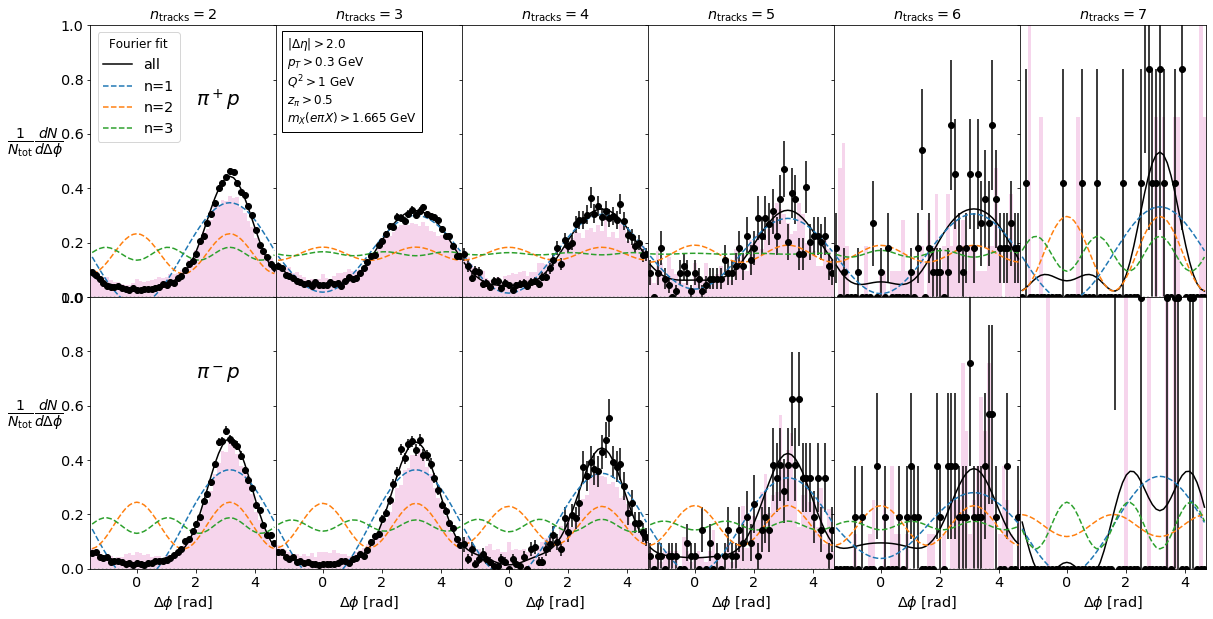

In [125]:
print(len(data_dihadrons),len(mc_dihadrons))


fig,axs = plt.subplots(2,6, figsize=(20,10),sharey='all', gridspec_kw={'hspace': 0, 'wspace':0})

for j,ntracks in enumerate([3,4,5,6,7,8]):
    for i,pid,pm in (0,211,"+"),(1,-211,'-'):
        for style,df_src in ('normal',data_dihadrons),("bar",mc_dihadrons):
            df = df_src.query("h1_cm_eta-h2_cm_eta>2.0  and h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                                     + " and h2_pid == 2212  and mx_eh1x>1.665 and h1_pid ==%s and ntracks==%s"% (pid,ntracks))
            plt.sca(axs[i][j])
            azimuthalPlot(df,n=3,includeLegend=(i==0 and j==0),style=style,expr="diff_phi_shift_truth" if style=='bar' else 'diff_phi_shift')
        if i == 0 and j==1:
            plt.gca().add_artist(AnchoredText("$|\\Delta\\eta|>2.0$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV\n$z_\\pi>0.5$\n$m_X(e\\pi X)>1.665$ GeV",
                                  loc='upper left',prop=dict(size=12)))
        if(j == 0):
            plt.text(2,0.7, "$\\pi^%sp$"%pm,fontsize=20)
        if(j != 0):
            plt.gca().set_ylabel('')
        if(i == 0):
            plt.gca().set_title("$n_{\\mathrm{tracks}}=%s$"%(ntracks-1))
        plt.gca().set_ylim(0,1)


plt.savefig("../images/fourier_dphi_pi_p_vs_ntracks_data_vs_mc.pdf",bbox_inches='tight')
plt.show()

<ipython-input-93-ce9548f3d4f6>:15: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(df_src.eval(expr),range=range,bins=30,label=lbl,histtype='step',normed=True,color=col)


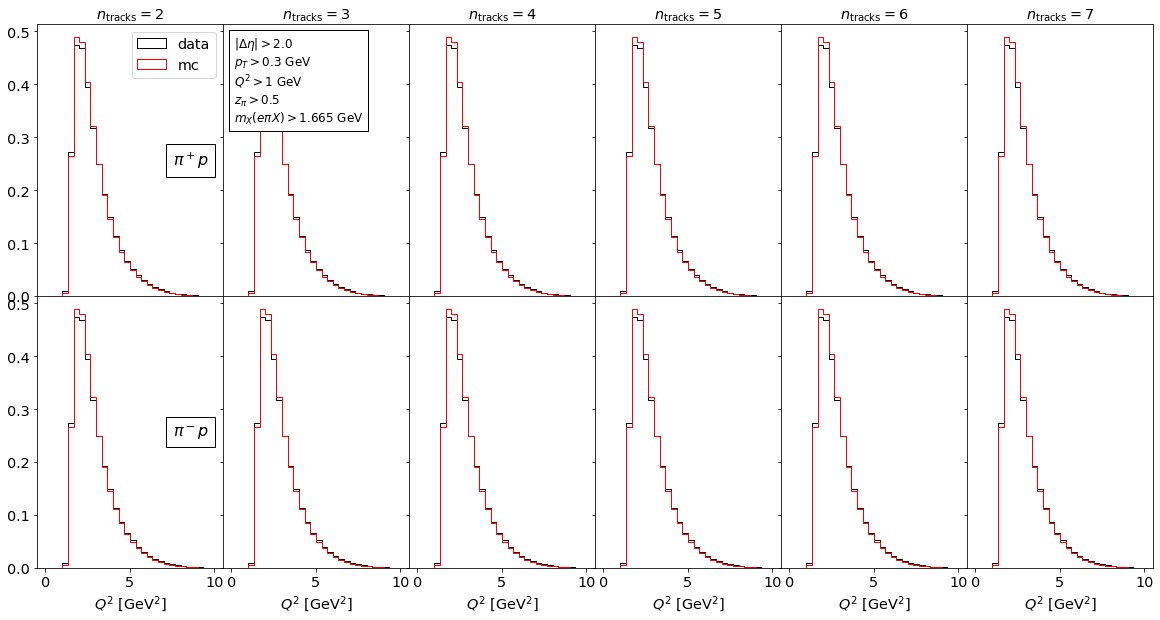

<ipython-input-93-ce9548f3d4f6>:15: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(df_src.eval(expr),range=range,bins=30,label=lbl,histtype='step',normed=True,color=col)


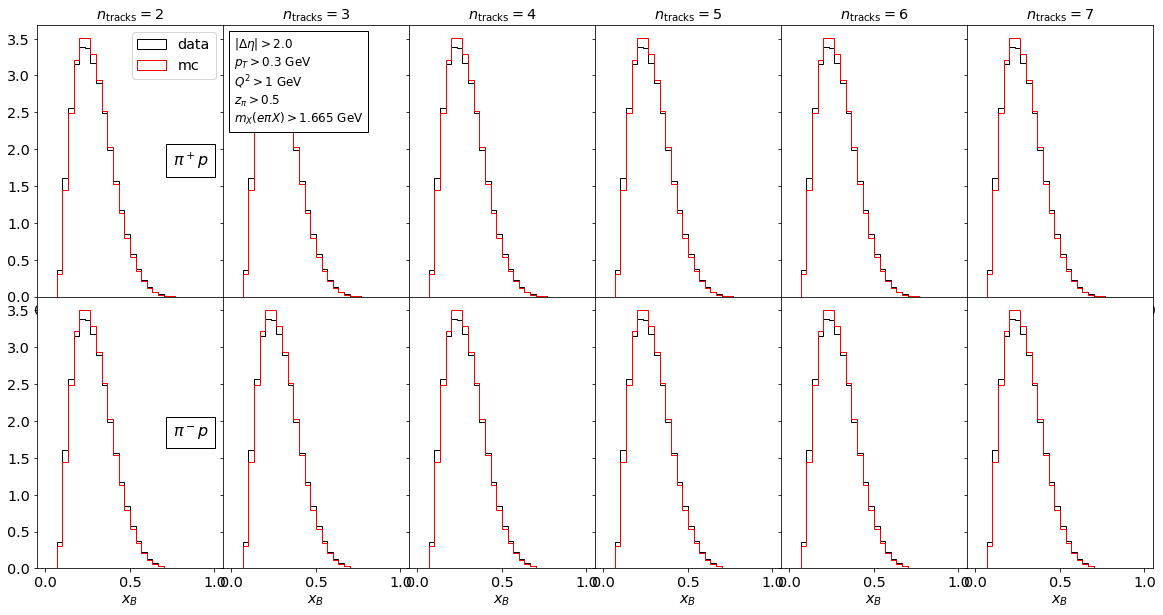

<ipython-input-93-ce9548f3d4f6>:15: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(df_src.eval(expr),range=range,bins=30,label=lbl,histtype='step',normed=True,color=col)


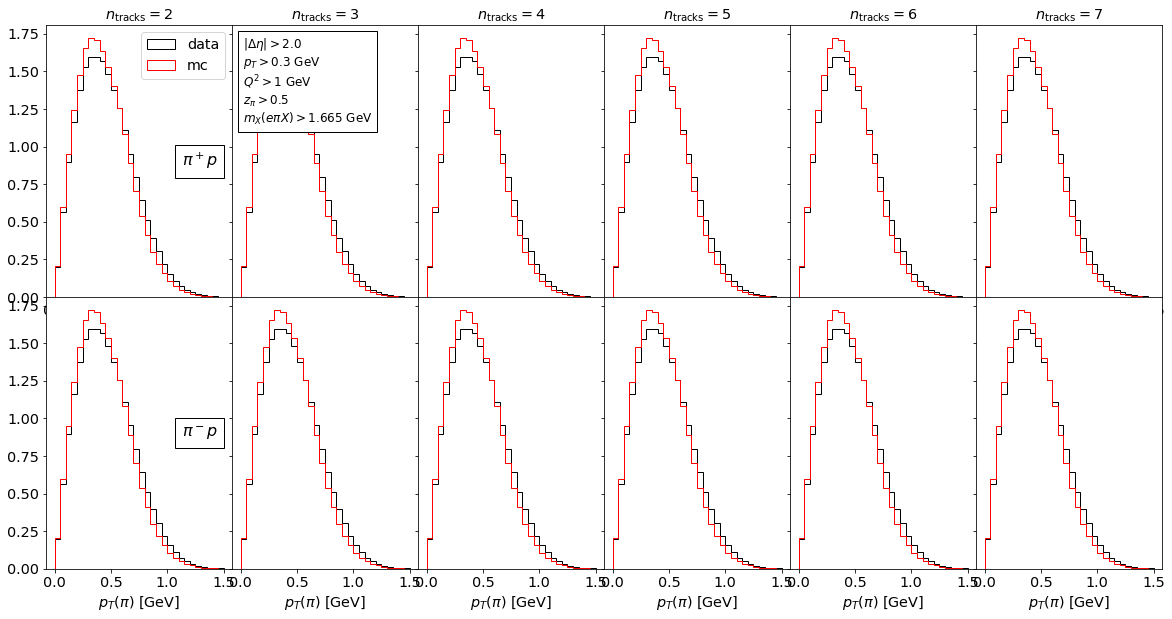

<ipython-input-93-ce9548f3d4f6>:15: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(df_src.eval(expr),range=range,bins=30,label=lbl,histtype='step',normed=True,color=col)


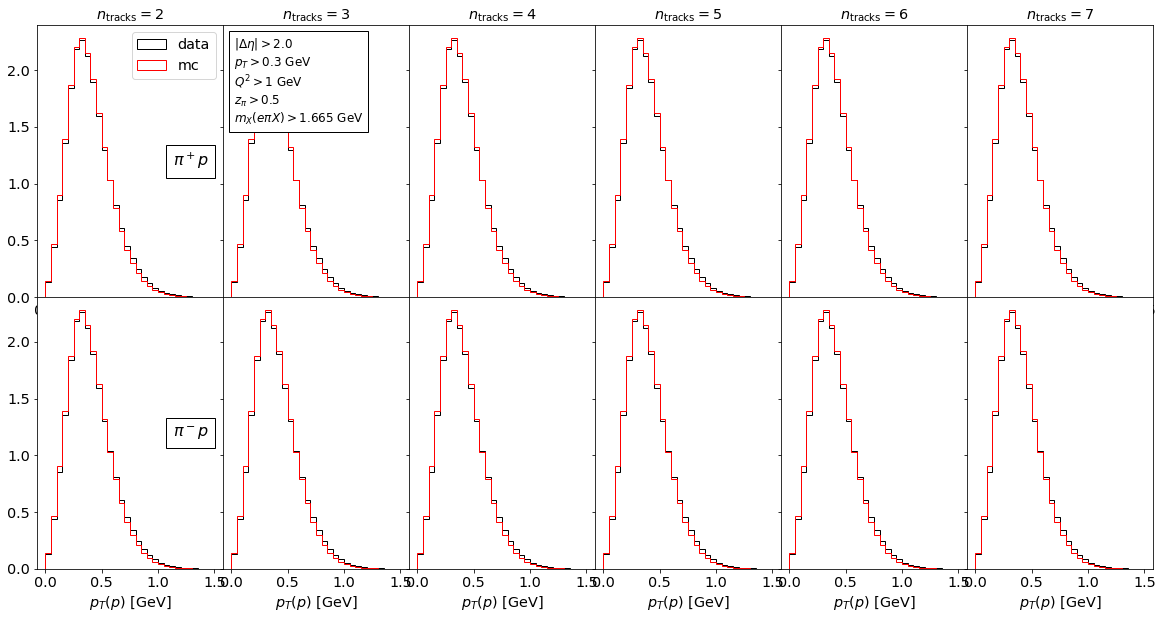

<ipython-input-93-ce9548f3d4f6>:15: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(df_src.eval(expr),range=range,bins=30,label=lbl,histtype='step',normed=True,color=col)


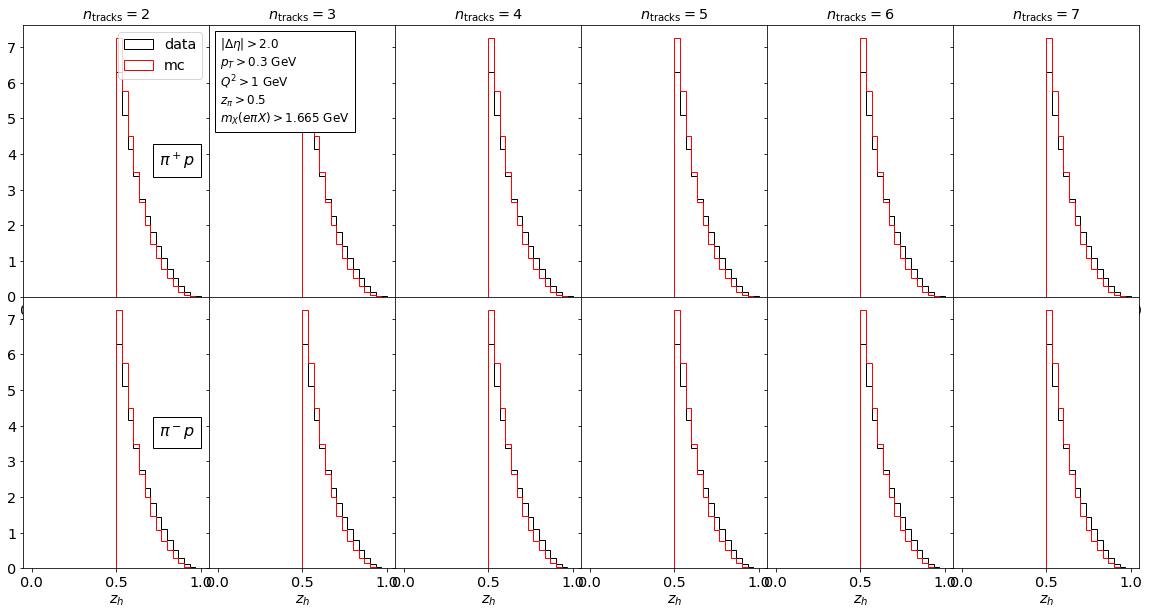

<ipython-input-93-ce9548f3d4f6>:15: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(df_src.eval(expr),range=range,bins=30,label=lbl,histtype='step',normed=True,color=col)


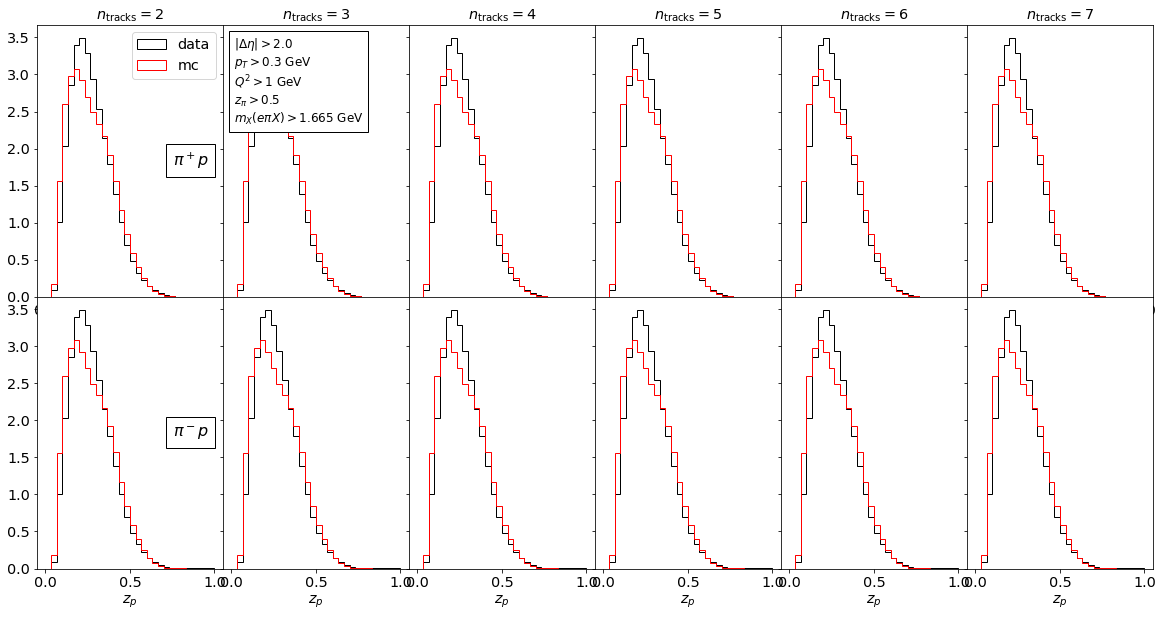

<ipython-input-93-ce9548f3d4f6>:15: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(df_src.eval(expr),range=range,bins=30,label=lbl,histtype='step',normed=True,color=col)


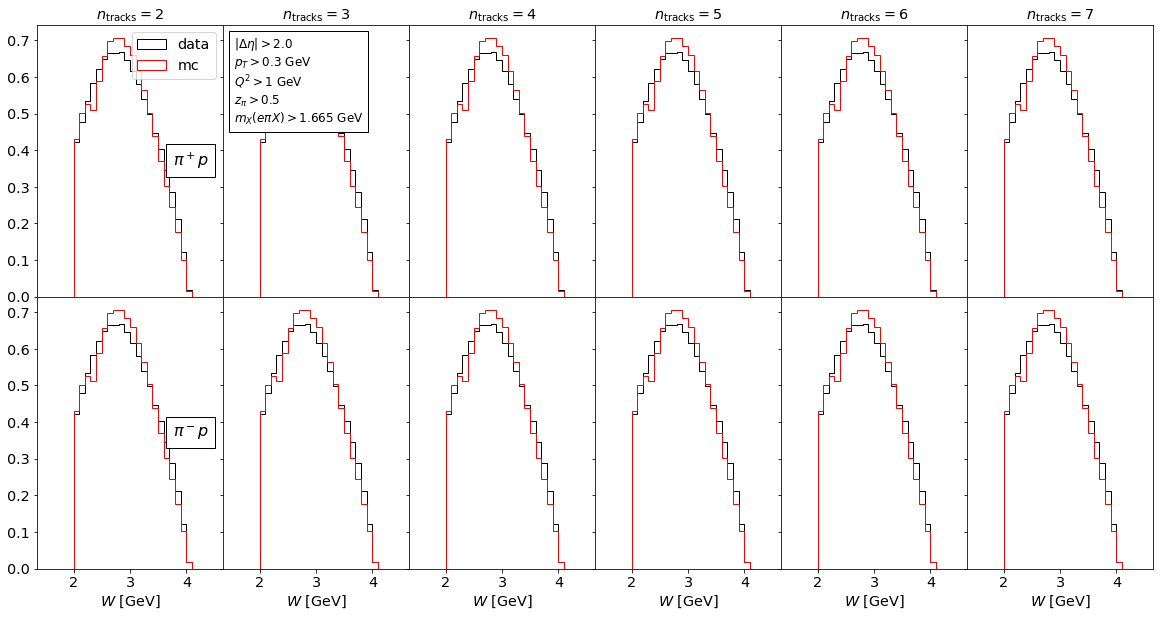

In [93]:

for expr, xlbl,range,tag in [("Q2","$Q^2$ [GeV$^2$]",(0,10),"Q2"),
        ("x","$x_B$",(0,1),"xb"),
        ("h1_cm_pt","$p_T(\\pi)$ [GeV]",(0,1.5),"pt1"),
        ("h2_cm_pt","$p_T(p)$ [GeV]",(0,1.5),"pt2"),
        ("h1_z","$z_h$",(0,1),"z1"),
        ("h2_z","$z_p$",(0,1),"z2"),
        ("W","$W$ [GeV]",(1.5,4.5),"W")]:
    fig,axs = plt.subplots(2,6, figsize=(20,10),sharey='all', gridspec_kw={'hspace': 0, 'wspace':0})
    for j,ntracks in enumerate([3,4,5,6,7,8]):
        for i,pid,pm in (0,211,"+"),(1,-211,'-'):
            for lbl,df_src,col in ('data',data_dihadrons,'k'),("mc",mc_dihadrons,'r'):
                df = df_src.query("h1_cm_eta-h2_cm_eta>2.0  and h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                                         + " and h2_pid == 2212  and mx_eh1x>1.665 and h1_pid == %s and ntracks==%s"% (pid,ntracks))
                plt.sca(axs[i][j])
                plt.hist(df_src.eval(expr),range=range,bins=30,label=lbl,histtype='step',normed=True,color=col)
            if i == 0 and j==1:
                
                plt.gca().add_artist(AnchoredText("$|\\Delta\\eta|>2.0$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV\n$z_\\pi>0.5$\n$m_X(e\\pi X)>1.665$ GeV",
                                      loc='upper left',prop=dict(size=12)))
            if(j == 0):
                plt.gca().add_artist(AnchoredText("$\\pi^%sp$"%pm,
                                      loc='center right',prop=dict(size=16)))
            if(j != 0):
                plt.gca().set_ylabel('')
            if(i == 0):
                plt.gca().set_title("$n_{\\mathrm{tracks}}=%s$"%(ntracks-1))
            if(i == 0 and j == 0):
                plt.legend()
            if(i == 1):
                plt.xlabel(xlbl)

    plt.savefig("../images/%s_pi_p_vs_ntracks_data_vs_mc.pdf"%tag,bbox_inches='tight')
    plt.show()

<ipython-input-116-d683ed3dd41e>:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(df["ntracks"]-1,range=(0,15),bins=15,label=lbl,histtype='step',normed=True,color=col)


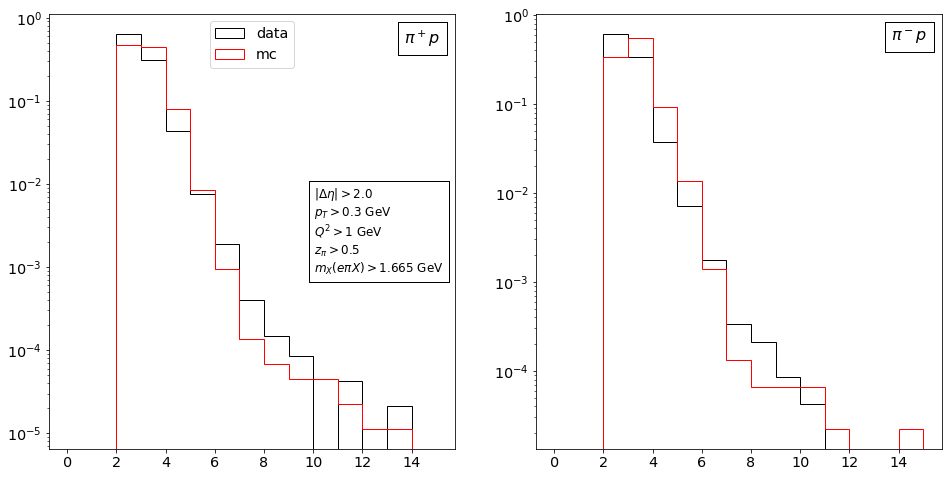

In [116]:
fig,axs = plt.subplots(1,2,figsize=(16,8))
for i,(pid,ax,pm) in enumerate(zip((211,-211),axs,['+','-'])):
    for lbl,df_src,col in ('data',data_dihadrons,'k'),("mc",mc_dihadrons,'r'):
        df = df_src.query("h1_cm_eta-h2_cm_eta>2.0  and h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                                             + " and h2_pid == 2212  and mx_eh1x>1.665 and h1_pid == %s"% pid)
        plt.sca(ax)
        plt.hist(df["ntracks"]-1,range=(0,15),bins=15,label=lbl,histtype='step',normed=True,color=col)
        if i== 0:
            plt.gca().add_artist(AnchoredText("$|\\Delta\\eta|>2.0$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV\n$z_\\pi>0.5$\n$m_X(e\\pi X)>1.665$ GeV",
                                      loc='center right',prop=dict(size=12)))
            plt.legend(loc='upper center')
       
        plt.gca().add_artist(AnchoredText("$\\pi^%sp$"%pm,
                                      loc='upper right',prop=dict(size=16)))
        plt.gca().set_yscale('log')
        
plt.savefig("../images/ntracks_data_vs_mc.pdf")

1 1.0 0 0
total time:  0 hours 0 minutes 1 seconds
0.0015326110317564414 0.95 0.0 0.0
total time:  0 hours 0 minutes 1 seconds
1e-05 1.0 0 0
total time:  0 hours 0 minutes 1 seconds
1e-05 1.0 0 0
total time:  0 hours 0 minutes 1 seconds
1e-05 1.0 0 0
total time:  0 hours 0 minutes 1 seconds
1e-05 1.0 0 0
total time:  0 hours 0 minutes 1 seconds
1e-05 1.0 0 0
total time:  0 hours 0 minutes 1 seconds
1e-05 1.0 0 0
total time:  0 hours 0 minutes 1 seconds
0.0028242425697559675 0.95 0.0 0.0
1 1.0 0 0
1 1.0 0 0
total time:  0 hours 0 minutes 1 seconds
0.0024078992741970394 0.95 0.0 0.0
total time:  0 hours 0 minutes 1 seconds
1e-05 1.0 0 0
total time:  0 hours 0 minutes 1 seconds
1e-05 1.0 0 0
total time:  0 hours 0 minutes 1 seconds
1e-05 1.0 0 0
total time:  0 hours 0 minutes 1 seconds
1e-05 1.0 0 0
total time:  0 hours 0 minutes 1 seconds
1e-05 1.0 0 0
total time:  0 hours 0 minutes 1 seconds
1e-05 0.97 0 0
total time:  0 hours 0 minutes 1 seconds
0.07129274492564376 0.95 0.0 0.0
1 1.0 0

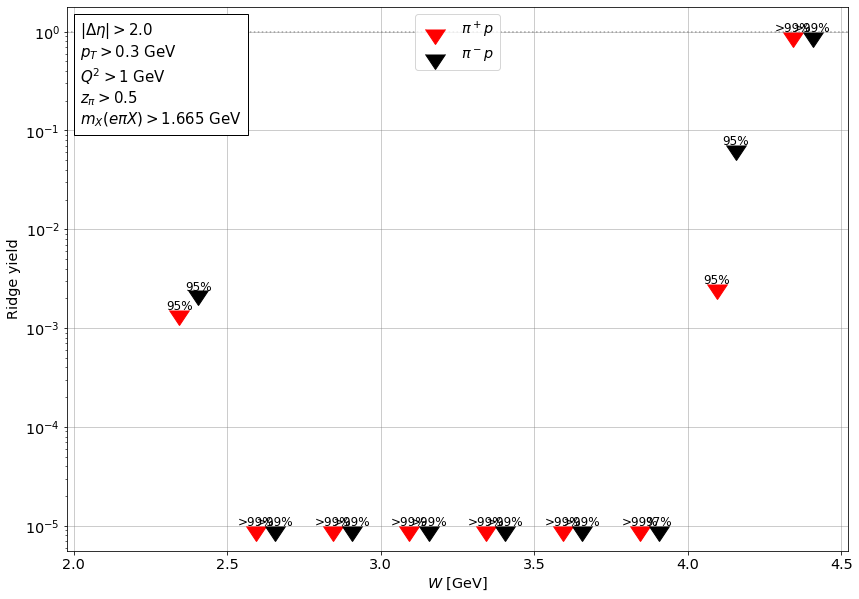

In [42]:
df = data_dihadrons.query("h1_cm_eta-h2_cm_eta>2.0 and h1_cm_eta-h2_cm_eta<200.0 and h1_cm_pt>0.3 and h2_cm_pt>0.3"\
        + " and h2_pid == 2212 and mx_eh1x>1.665")
plt.subplots(1,1, figsize=(14,10))    
exclusion_plot(df, "W",2,4.5,10)
plt.gca().set_xlabel("$W$ [GeV]")

plt.gca().add_artist(AnchoredText("$|\\Delta\\eta|>2.0$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV\n$z_\\pi>0.5$\n$m_X(e\\pi X)>1.665$ GeV",
                                  loc='upper left',prop=dict(size=15)))

plt.gca().legend(loc='upper center')
plt.savefig("../images/ridge_yield_UL_vs_W.pdf")
plt.show()

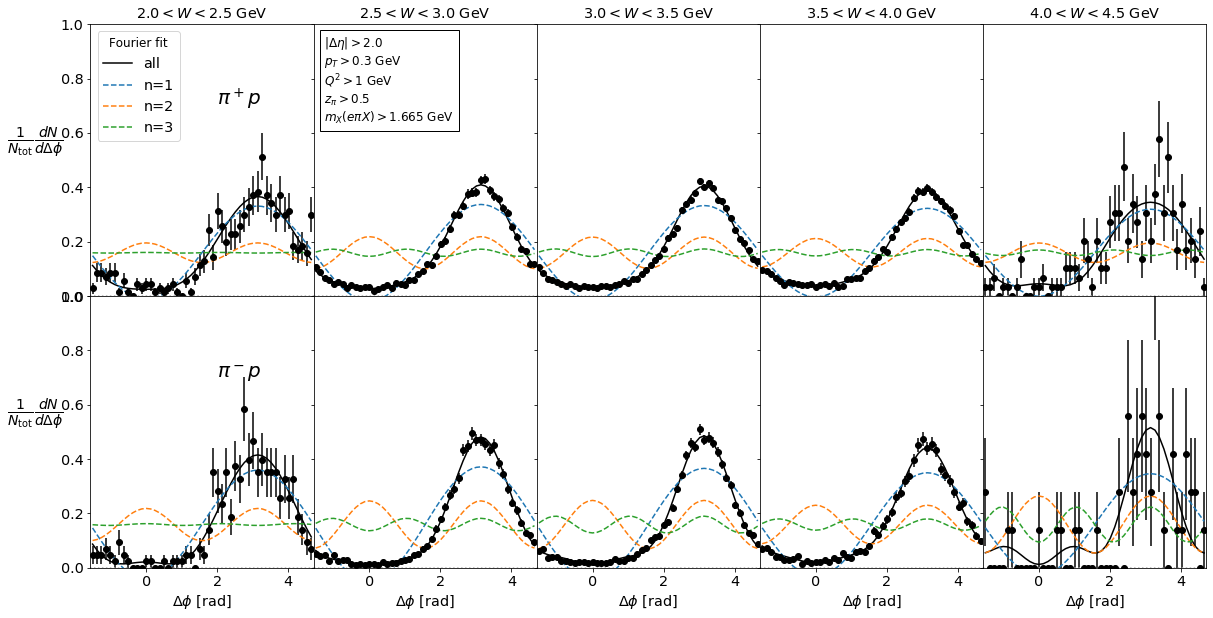

In [57]:
fig,axs = plt.subplots(2,5, figsize=(20,10),sharey='all', gridspec_kw={'hspace': 0, 'wspace':0})
for j,(mn,mx) in enumerate([(2.0,2.50),(2.50,3.0),(3.00,3.5),(3.5,4.0),(4.0,4.5)]):
    for i,pid,pm in (0,211,"+"),(1,-211,'-'):
        df = data_dihadrons.query("h1_cm_eta-h2_cm_eta>2.0  and h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                                 + " and h2_pid == 2212  and mx_eh1x>1.665 and h1_pid ==%s and W>%s and W < %s"% (pid,mn,mx))
        plt.sca(axs[i][j])
        azimuthalPlot(df,n=3,includeLegend=(i==0 and j==0))
        if i == 0 and j==1:
            plt.gca().add_artist(AnchoredText("$|\\Delta\\eta|>2.0$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV\n$z_\\pi>0.5$\n$m_X(e\\pi X)>1.665$ GeV",
                                  loc='upper left',prop=dict(size=12)))
        if(j == 0):
            plt.text(2,0.7, "$\\pi^%sp$"%pm,fontsize=20)
        if(j != 0):
            plt.gca().set_ylabel('')
        if(i == 0):
            plt.gca().set_title("$%s<W<%s$ GeV"%(mn,mx))
        plt.gca().set_ylim(0,1)


plt.savefig("../images/fourier_dphi_pi_p_vs_W.pdf",bbox_inches='tight')
plt.show()

(array([6.000e+00, 1.600e+01, 9.100e+01, 2.500e+02, 4.430e+02, 6.240e+02,
        8.750e+02, 1.109e+03, 1.255e+03, 1.398e+03, 1.404e+03, 1.596e+03,
        1.729e+03, 1.809e+03, 1.896e+03, 1.900e+03, 1.965e+03, 1.954e+03,
        1.988e+03, 2.046e+03, 2.021e+03, 2.052e+03, 1.988e+03, 1.895e+03,
        1.970e+03, 1.912e+03, 1.827e+03, 1.817e+03, 1.725e+03, 1.658e+03,
        1.642e+03, 1.557e+03, 1.475e+03, 1.436e+03, 1.359e+03, 1.303e+03,
        1.307e+03, 1.145e+03, 1.140e+03, 1.077e+03, 1.007e+03, 9.580e+02,
        8.940e+02, 8.750e+02, 8.140e+02, 7.210e+02, 6.730e+02, 6.290e+02,
        5.690e+02, 5.990e+02, 5.470e+02, 5.160e+02, 4.790e+02, 3.840e+02,
        3.750e+02, 3.730e+02, 3.460e+02, 3.240e+02, 2.800e+02, 2.880e+02,
        2.830e+02, 2.140e+02, 1.970e+02, 1.710e+02, 1.720e+02, 1.490e+02,
        1.390e+02, 1.280e+02, 1.170e+02, 9.800e+01, 8.500e+01, 8.900e+01,
        6.700e+01, 7.300e+01, 7.000e+01, 5.200e+01, 5.100e+01, 5.400e+01,
        3.100e+01, 2.400e+01, 3.300e+0

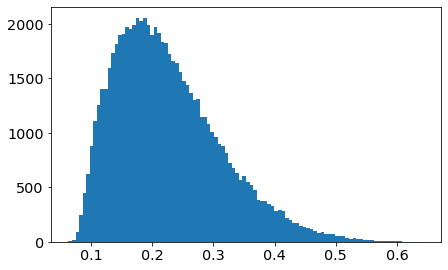

In [22]:
df = data_dihadrons.query("h1_cm_eta-h2_cm_eta>2.0 and h1_cm_eta-h2_cm_eta<200.0 and h1_cm_pt>0.3 and h2_cm_pt>0.3"\
        + " and h2_pid == 2212 and mx_eh1x>1.665")
plt.hist(df.x,bins=100)

total time:  0 hours 0 minutes 1 seconds
1e-05 1.0 0 0
total time:  0 hours 0 minutes 1 seconds
1e-05 1.0 0 0
total time:  0 hours 0 minutes 1 seconds
1e-05 1.0 0 0
total time:  0 hours 0 minutes 1 seconds
1e-05 1.0 0 0
total time:  0 hours 0 minutes 1 seconds
1e-05 1.0 0 0
total time:  0 hours 0 minutes 1 seconds
0.006469045144754201 0.95 0.0 0.0
total time:  0 hours 0 minutes 1 seconds
1.375929790681837 0.95 0.0 0.0
1 1.0 0 0
1 1.0 0 0
1 1.0 0 0
total time:  0 hours 0 minutes 1 seconds
1e-05 0.98 0 0
total time:  0 hours 0 minutes 1 seconds
1e-05 1.0 0 0
total time:  0 hours 0 minutes 1 seconds
1e-05 1.0 0 0
total time:  0 hours 0 minutes 1 seconds
1e-05 1.0 0 0
total time:  0 hours 0 minutes 1 seconds
0.0004966063415322955 0.95 0.0 0.0
total time:  0 hours 0 minutes 1 seconds
0.025694501950799038 0.95 0.0038583426181818064 0.0
total time:  0 hours 0 minutes 1 seconds
0.5227878569392758 0.95 0.0 0.0
1 1.0 0 0
1 1.0 0 0
1 1.0 0 0


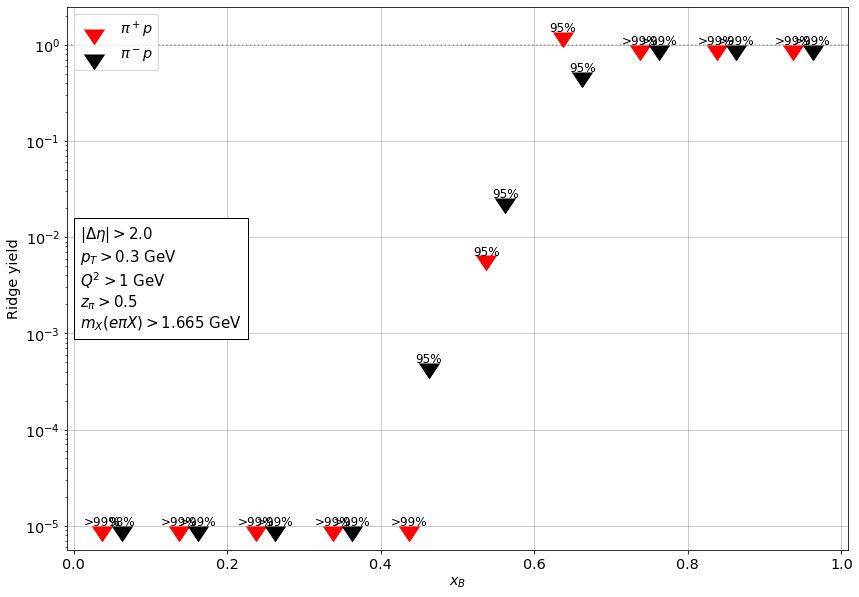

In [15]:
df = data_dihadrons.query("h1_cm_eta-h2_cm_eta>2.0 and h1_cm_eta-h2_cm_eta<200.0 and h1_cm_pt>0.3 and h2_cm_pt>0.3"\
        + " and h2_pid == 2212 and mx_eh1x>1.665")
plt.subplots(1,1, figsize=(14,10))    
exclusion_plot(df, "x",0,1,10)

plt.gca().add_artist(AnchoredText("$|\\Delta\\eta|>2.0$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV\n$z_\\pi>0.5$\n$m_X(e\\pi X)>1.665$ GeV",
                                  loc='center left',prop=dict(size=15)))

plt.gca().legend(loc='upper left')
plt.gca().set_xlabel("$x_B$")
plt.savefig("../images/ridge_yield_UL_vs_xb.pdf")
plt.show()

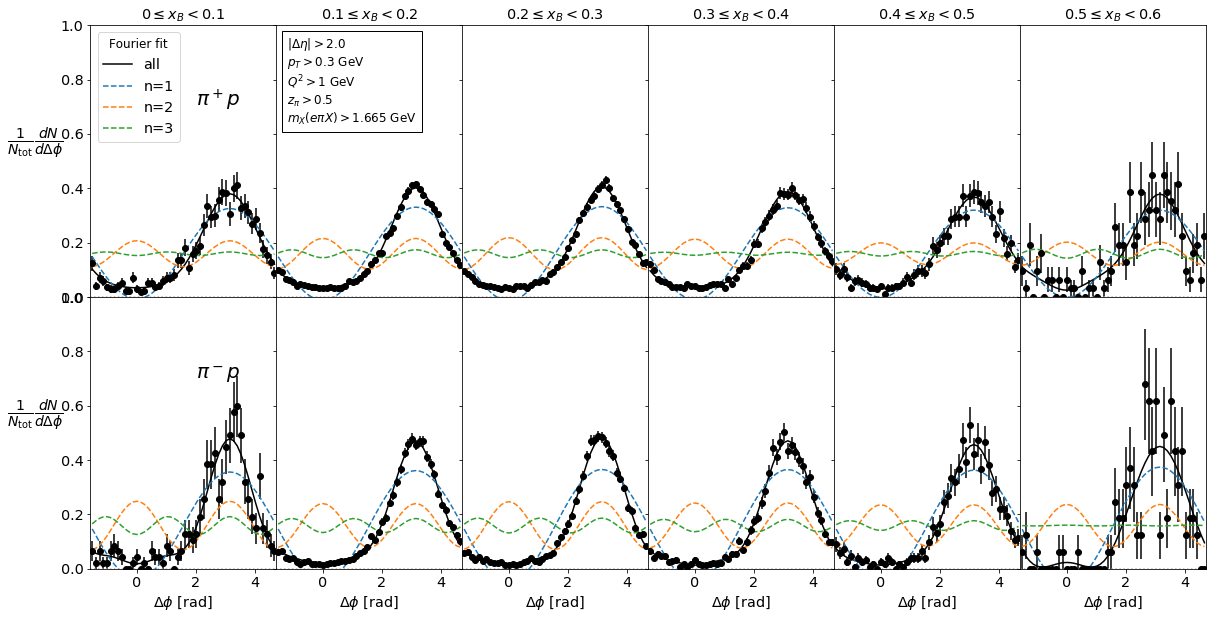

In [23]:
fig,axs = plt.subplots(2,6, figsize=(20,10),sharey='all', gridspec_kw={'hspace': 0, 'wspace':0})
partitions=[0,0.1,0.2,0.3,0.4,0.5,0.6]
for j,(mn,mx) in enumerate(zip(partitions[:-1],partitions[1:])):
    for i,pid,pm in (0,211,"+"),(1,-211,'-'):
        df = data_dihadrons.query("h1_cm_eta-h2_cm_eta>2.0  and h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                                 + " and h2_pid == 2212  and mx_eh1x>1.665 and h1_pid ==%s and x>=%s and x<%s"% (pid,mn,mx))
        plt.sca(axs[i][j])
        azimuthalPlot(df,n=3,includeLegend=(i==0 and j==0))
        if i == 0 and j==1:
            plt.gca().add_artist(AnchoredText("$|\\Delta\\eta|>2.0$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV\n$z_\\pi>0.5$\n$m_X(e\\pi X)>1.665$ GeV",
                                  loc='upper left',prop=dict(size=12)))
        if(j == 0):
            plt.text(2,0.7, "$\\pi^%sp$"%pm,fontsize=20)
        if(j != 0):
            plt.gca().set_ylabel('')
        if(i == 0):
            plt.gca().set_title("$%s\\leq x_B<%s$"%(mn,mx))
        plt.gca().set_ylim(0,1)


plt.savefig("../images/fourier_dphi_pi_p_vs_xb.pdf",bbox_inches='tight')
plt.show()